In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv', index_col = 'DATE', parse_dates = True)

In [3]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

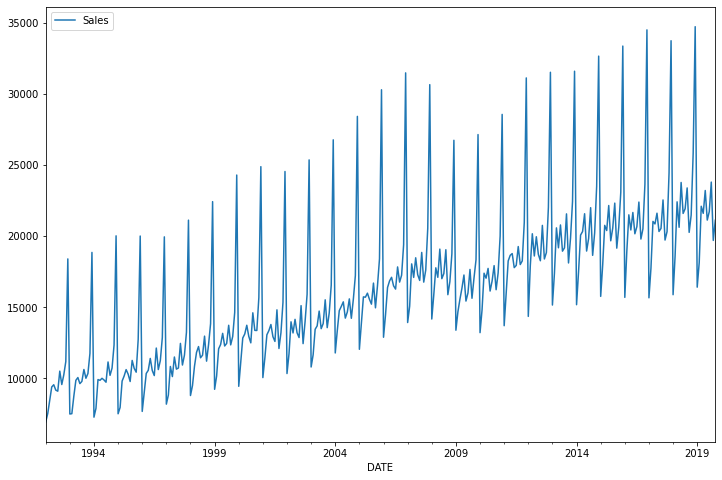

In [4]:
df.plot(figsize = (12, 8))

In [5]:
len(df)

334

In [6]:
len(df) - 18     # taking 18 months for test data

316

In [7]:
test_size = 18
test_index = len(df) - test_size

In [8]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [9]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [10]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
scaled_train = scaler.fit_transform(train)

In [13]:
scaled_test = scaler.transform(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
len(test)

18

In [16]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)

In [17]:
X, Y = generator[0]

In [18]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [19]:
Y

array([[0.02047633]])

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [21]:
n_features = 1

In [22]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [26]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = 1)

In [27]:
%%time
model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop])

Epoch 1/20


<timed eval>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


304/304 [==============================] - 7s 19ms/step - loss: 0.0228 - val_loss: 0.0042
Epoch 2/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0189 - val_loss: 0.0028
Epoch 3/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0137 - val_loss: 0.0013
Epoch 4/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 5/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0039 - val_loss: 9.4685e-04
Epoch 6/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0018 - val_loss: 8.0071e-04
Epoch 8/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0017 - val_loss: 3.2504e-04
Epoch 9/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0012 - val_l

In [28]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

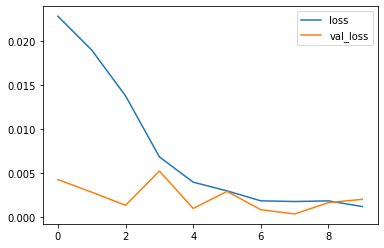

In [29]:
losses.plot()

In [30]:
test_pred  = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [31]:
true_pred = scaler.inverse_transform(test_pred)

In [32]:
test['Predictions'] = true_pred

C:\Users\91773\AppData\Local\Temp\ipykernel_14380\3456487850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


In [33]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22356.429324
2018-06-01,21589,21062.423052
2018-07-01,21919,21342.891471
2018-08-01,23381,23371.791162
2018-09-01,20260,20513.323235
2018-10-01,21473,21286.242876
2018-11-01,25831,25720.127858
2018-12-01,34706,35782.499394
2019-01-01,16410,16240.347845


<AxesSubplot:xlabel='DATE'>

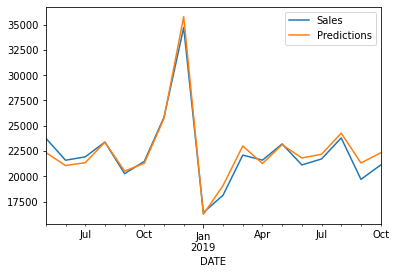

In [34]:
test.plot()

In [36]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [37]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [38]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

UsageError: Line magic function `%%time` not found.


In [39]:
%%time
model.fit_generator(generator, epochs = 10)

Epoch 1/10


<timed eval>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


322/322 [==============================] - 6s 18ms/step - loss: 0.0236
Epoch 2/10
322/322 [==============================] - 6s 17ms/step - loss: 0.0152
Epoch 3/10
322/322 [==============================] - 6s 17ms/step - loss: 0.0079
Epoch 4/10
322/322 [==============================] - 6s 17ms/step - loss: 0.0038
Epoch 5/10
322/322 [==============================] - 6s 17ms/step - loss: 0.0024
Epoch 6/10
322/322 [==============================] - 6s 18ms/step - loss: 0.0028
Epoch 7/10
322/322 [==============================] - 5s 17ms/step - loss: 0.0011
Epoch 8/10
322/322 [==============================] - 6s 17ms/step - loss: 0.0011
Epoch 9/10
322/322 [==============================] - 5s 17ms/step - loss: 0.0011
Epoch 10/10
322/322 [==============================] - 6s 18ms/step - loss: 0.0015
CPU times: total: 2min
Wall time: 56.7 s


In [40]:
forecast = []

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [41]:
forecast = scaler.inverse_transform(forecast)

In [42]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [43]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

In [44]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [45]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [46]:
forecast_df

,Forecast
2019-11-01,27705.726384
2019-12-01,37338.609466
2020-01-01,17594.983957
2020-02-01,19617.403659
2020-03-01,23642.432063
2020-04-01,23250.597152
2020-05-01,24892.288385
2020-06-01,22894.099276
2020-07-01,23566.639017
2020-08-01,25587.942329


<AxesSubplot:>

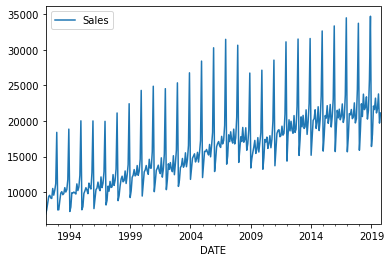

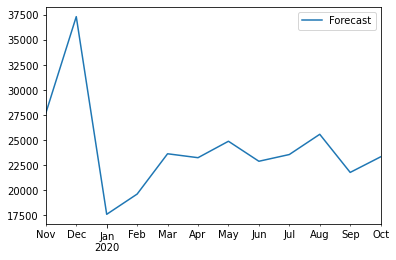

In [47]:
df.plot()
forecast_df.plot()

(576.0, 611.0)

<Figure size 1080x576 with 0 Axes>

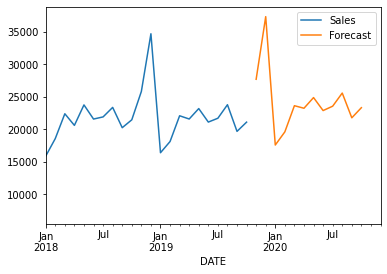

In [51]:
plt.figure(figsize = (15, 8))
axis = df.plot()
forecast_df.plot(ax = axis)
plt.xlim('2018-01-01', '2020-12-01')